In [5]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
! pip install rdkit pubchempy pyxlsb xlrd -q

In [6]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Main Dataset - Exploratory Analysis

In [7]:
df= pd.read_csv("Maindataset.csv")
df

,CAS Number,Chemical Name,Species Scientific Name,Species Group,Conc Mean,Conc Units,Endpoint
0,50000,Formaldehyde,Lithobates catesbeianus,Amphibians,0.5,AI mg/L,NOEC
1,50000,Formaldehyde,Lithobates catesbeianus,Amphibians,0.5,AI mg/L,NOEC
2,50022,"11beta,16alpha-9-Fluoro-11,17,21-Trihydroxy-16...",Ambystoma mexicanum,Amphibians,50.0,ug,NOEC
3,50022,"11beta,16alpha-9-Fluoro-11,17,21-Trihydroxy-16...",Ambystoma mexicanum,Amphibians,100.0,ug,NOEC
4,50022,"11beta,16alpha-9-Fluoro-11,17,21-Trihydroxy-16...",Ambystoma mexicanum,Amphibians,50.0,ug,NOEC
...,...,...,...,...,...,...,...
442329,1314643,"Uranium, dioxo sulfato(2-)-O]-",Hydra viridissima,Other Invertebrates,150,µg/l,LOEC
442330,5466773,2-Ethylexyl 4-methoxycinnamate,Melanoides tuberculata,Molluscs,10,mg/kg,LOEC
442331,298464,Carbamazepine,Chironomus riparius,Insects/Spiders,0.233999997,mg/kg,LOEC
442332,10048950,Dinatriumarsenat Heptahydrat,Branchiura sowerbyi,Worms,42,mg/kg,LOEC


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442334 entries, 0 to 442333
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   CAS Number               442334 non-null  object
 1   Chemical Name            442334 non-null  object
 2   Species Scientific Name  442334 non-null  object
 3   Species Group            442334 non-null  object
 4   Conc Mean                435449 non-null  object
 5   Conc Units               442334 non-null  object
 6   Endpoint                 442334 non-null  object
dtypes: object(7)
memory usage: 23.6+ MB


In [9]:
df.describe(include='object')

,CAS Number,Chemical Name,Species Scientific Name,Species Group,Conc Mean,Conc Units,Endpoint
count,442334,442334,442334,442334,435449,442334,442334
unique,11065,7826,5623,24,38169,417,4
top,7758987,Sulfuric acid copper(2+) salt (1:1),Danio rerio,Fish,10,AI mg/L,NOEC
freq,11002,15791,40325,201665,8335,273177,140324


In [10]:
df['Species Group'] = df['Species Group'].str.replace('/', '&', regex=False).str.split(';').str[0]
df['Species Group'].value_counts()

Species Group
Fish                             201665
Crustaceans                       70541
Algae                             35233
Insects&Spiders                   34672
Molluscs                          24700
Flowers, Trees, Shrubs, Ferns     21672
Amphibians                        17725
Other Invertebrates               13214
Worms                             13211
Birds                              3650
Fungi                              3436
Mammals                            1412
Reptiles                            350
Microorganisms                      329
Moss, Hornworts                     263
Dicotyledons                         96
Cyanophyceae                         48
Echinodermata                        39
Mussels                              37
Rotifers                             26
Periphyton                            6
Myriapoda                             5
Conifers                              2
Mikrokosmos                           2
Name: count, dtype: int64

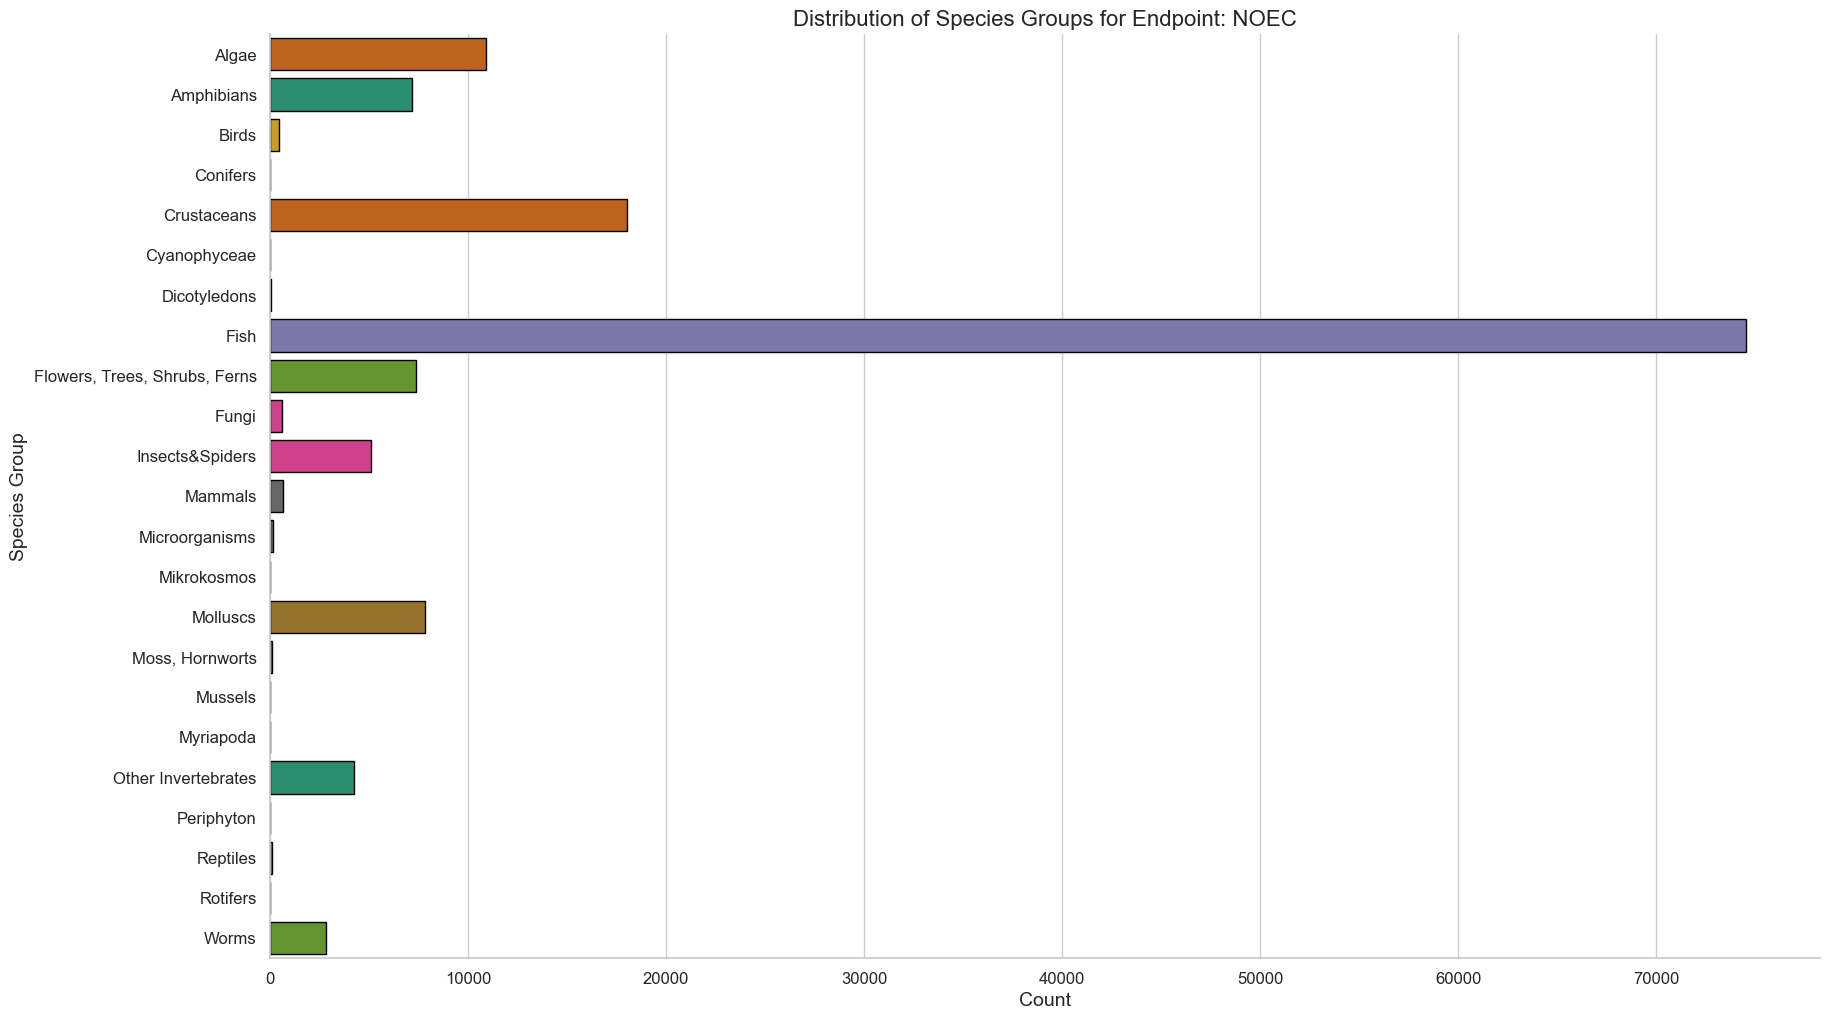

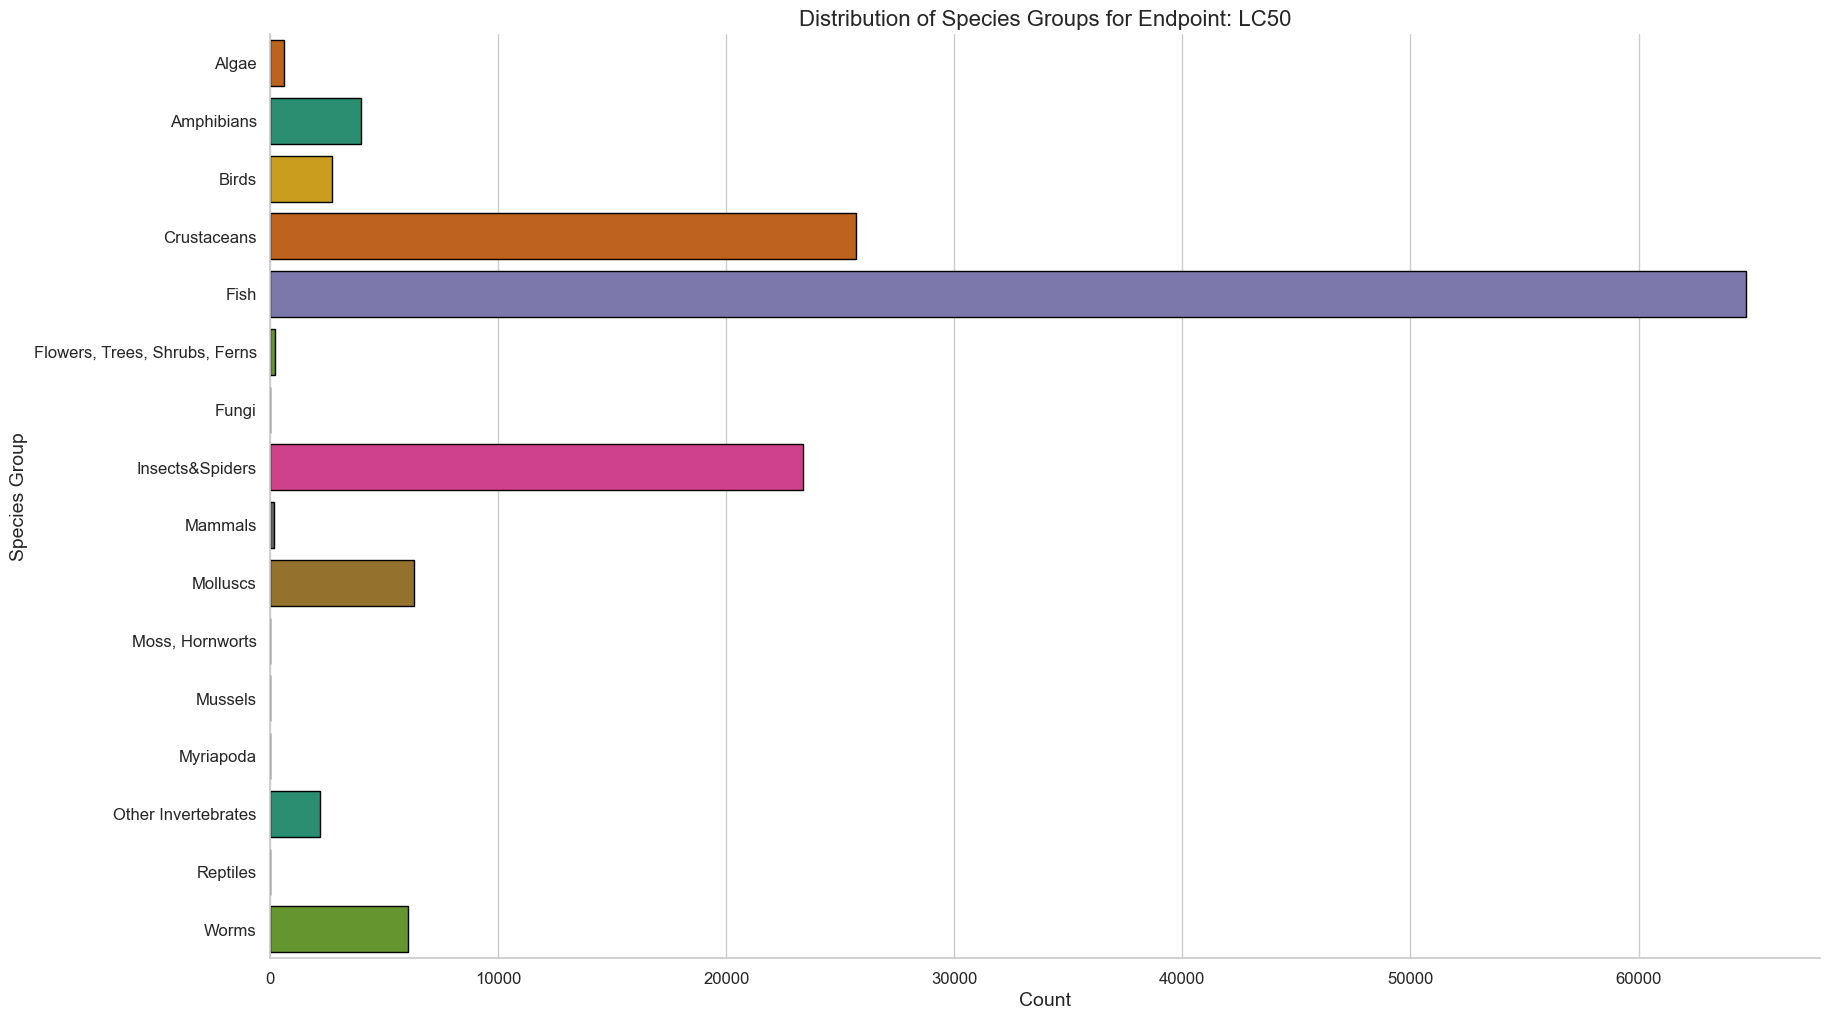

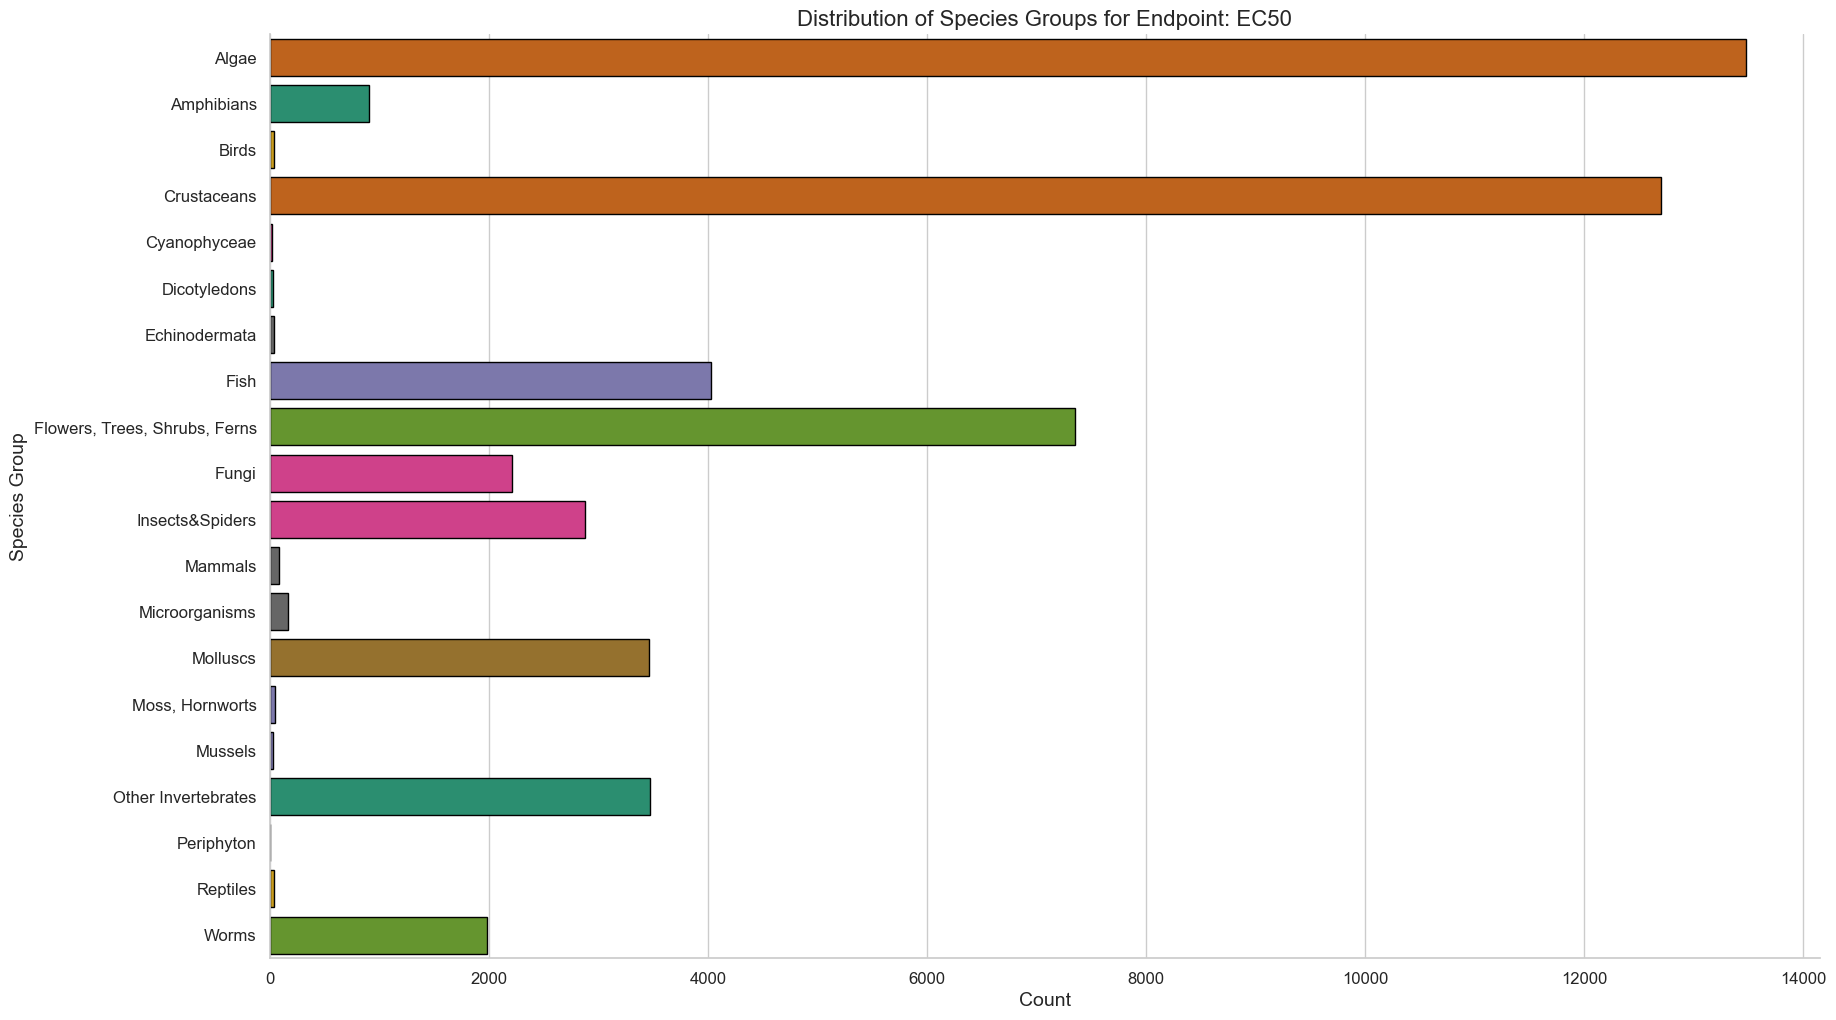

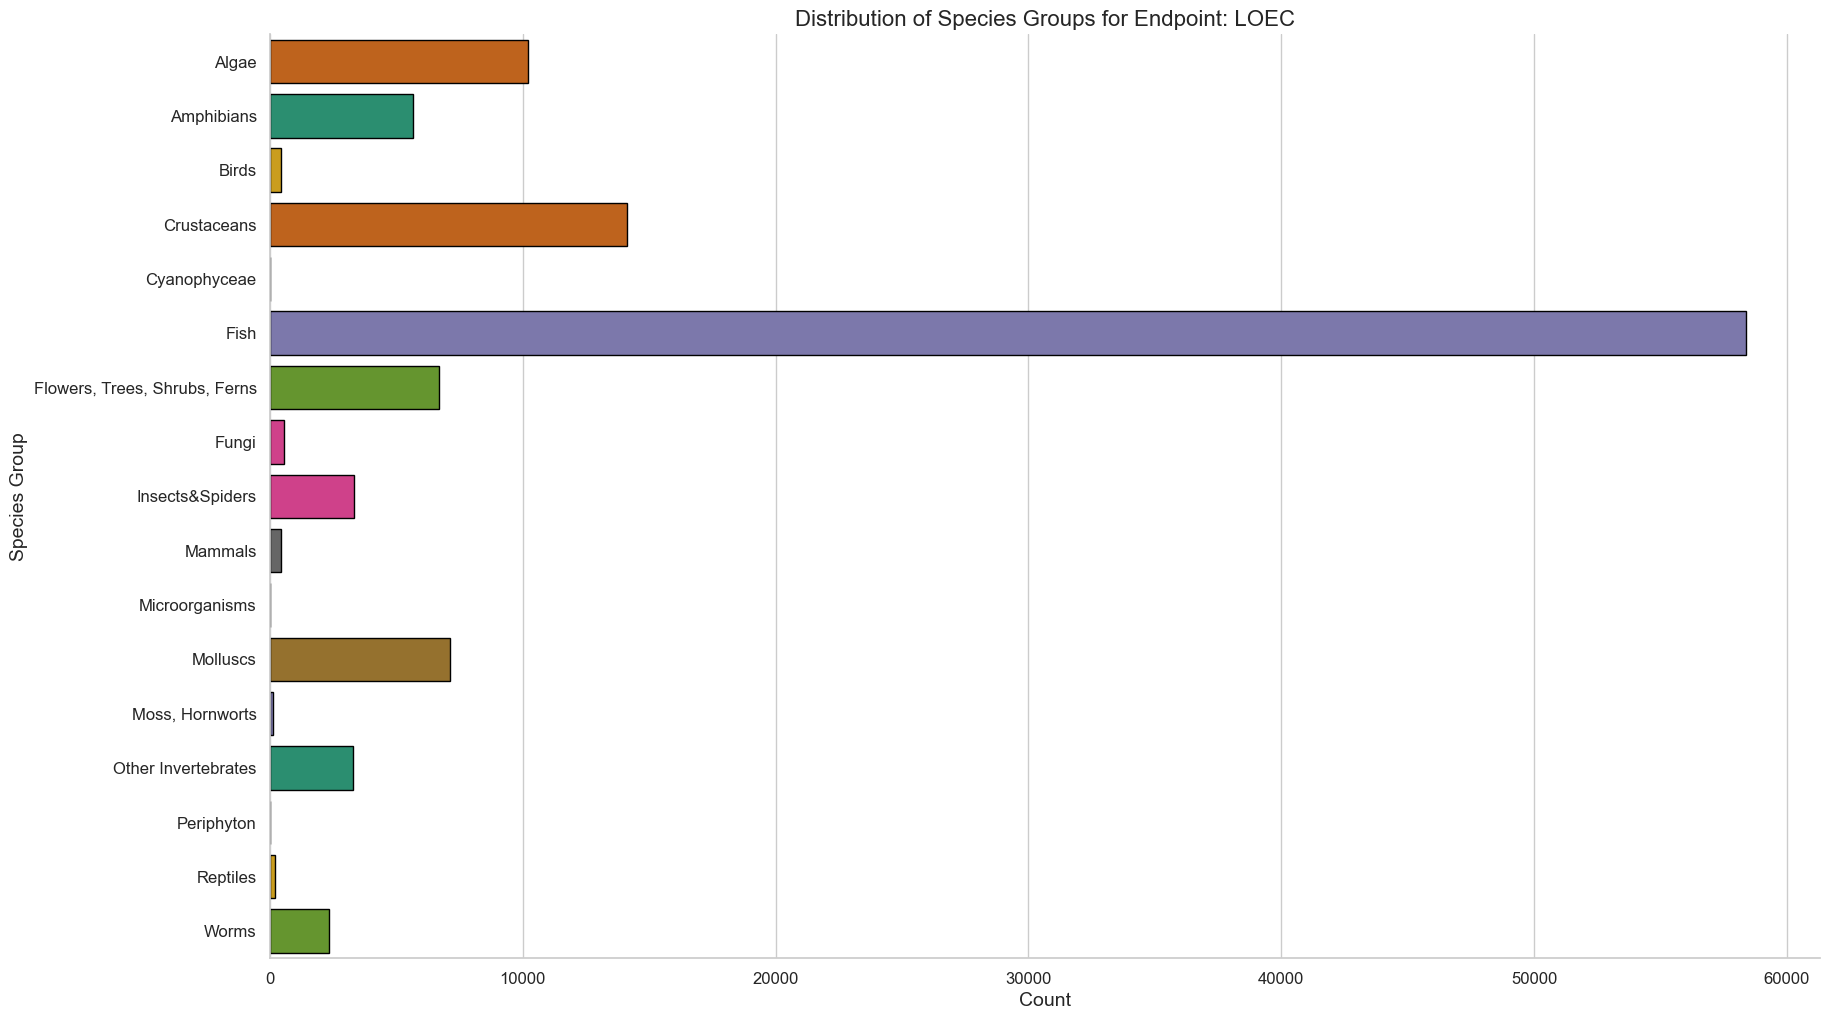

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a seaborn style
sns.set(style="whitegrid")
# plt.tight_layout()  # Adjust layout to make room for labels

# Unique endpoints from df_life_stage
endpoints = df['Endpoint'].unique()

# Create a consistent color palette for all species common names
species_common_names = df['Species Group'].unique()
palette = sns.color_palette("Dark2", n_colors=len(species_common_names))
color_map = {species: color for species, color in zip(species_common_names, palette)}

# Iterate through each endpoint type and plot
for endpoint in endpoints:
    # Filter data for the current endpoint
    data = df[df['Endpoint'] == endpoint].groupby('Species Group').size()

    # Sort index to ensure consistent order in all plots
    data = data.sort_index()

    # Create the bar plot with a consistent color map
    plt.figure(figsize=(20, 12))
    ax = sns.barplot(y=data.index, x=data.values, palette=[color_map[sp] for sp in data.index], edgecolor='black')

    # Customizing the plot
    ax.set_title(f'Distribution of Species Groups for Endpoint: {endpoint}', fontsize=16)
    ax.set_xlabel('Count', fontsize=14)
    ax.set_ylabel('Species Group', fontsize=14)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)

    # Remove unnecessary spines
    sns.despine()

    # Save each plot as a high-resolution PNG file
    plt.savefig(f'{endpoint}.png')

    # Show the plot
    plt.show()

In [27]:
# Calculate the value counts for the 'Species Group' column
species_counts = df['Species Group'].value_counts()

# Filter the counts to include only those greater than 1000
filtered_counts = species_counts[species_counts > 1000]
list(filtered_counts.keys())

['Fish',
 'Crustaceans',
 'Algae',
 'Insects&Spiders',
 'Molluscs',
 'Flowers, Trees, Shrubs, Ferns',
 'Amphibians',
 'Other Invertebrates',
 'Worms',
 'Birds',
 'Fungi',
 'Mammals']

In [28]:
df.to_csv('MaindatasetProcessed.csv', index=False)

In [29]:
import pandas as pd

# Load your data
df = pd.read_csv("MaindatasetProcessed.csv")  
# Iterate through each unique endpoint
for endpoint_value in df['Endpoint'].unique():
    # Filter DataFrame by endpoint
    subset_df = df[df['Endpoint'] == endpoint_value]
    
    # Define the file name for each endpoint
    file_name = f"{endpoint_value}.csv"
    
    # Save the subset to a new file
    subset_df.to_csv(file_name, index=False)
    print(f"Saved {file_name}")


Saved NOEC.csv
Saved LC50.csv
Saved EC50.csv
Saved LOEC.csv


# Concentration Units Standardisation

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv('LOEC.csv')
df

,CAS Number,Chemical Name,Species Scientific Name,Species Group,Conc Mean,Conc Units,Endpoint
0,57410,"5,5-Diphenyl-2,4-imidazolidinedione",Lithobates pipiens,Amphibians,20,mg/kg,LOEC
1,7487947,Mercury chloride (HgCl2),Rana cyanophlyctis,Amphibians,0.96,mg/L,LOEC
2,7487947,Mercury chloride (HgCl2),Rana cyanophlyctis,Amphibians,0.96,mg/L,LOEC
3,7487947,Mercury chloride (HgCl2),Rana cyanophlyctis,Amphibians,0.96,mg/L,LOEC
4,7487947,Mercury chloride (HgCl2),Rana cyanophlyctis,Amphibians,0.96,mg/L,LOEC
...,...,...,...,...,...,...,...
112861,1314643,"Uranium, dioxo sulfato(2-)-O]-",Hydra viridissima,Other Invertebrates,150,µg/l,LOEC
112862,5466773,2-Ethylexyl 4-methoxycinnamate,Melanoides tuberculata,Molluscs,10,mg/kg,LOEC
112863,298464,Carbamazepine,Chironomus riparius,Insects&Spiders,0.233999997,mg/kg,LOEC
112864,10048950,Dinatriumarsenat Heptahydrat,Branchiura sowerbyi,Worms,42,mg/kg,LOEC


In [82]:
conc_units = df['Conc Units '].value_counts().to_dict()
for key, value in conc_units.items():
    print(key, ':   ', value)

ug/L :    34337
mg/L :    30858
uM :    8123
ppm :    5962
ng/L :    3334
mM :    2634
ppb :    2455
AI ug/L :    1809
AI mg/L :    1701
ug/ml :    1533
nM :    1468
mg/kg bdwt :    1106
M :    1068
umol/L :    914
mg/kg :    769
ug/kg bdwt :    749
mmol/L :    563
mg/kg bdwt/d :    503
ae mg/L :    497
mg/kg soil :    457
% :    444
ng/ml :    423
g/L :    411
mg/kg diet :    407
ug/g diet :    366
AI g/ha :    341
ug/org :    333
ug/g bdwt :    330
ug/kg :    322
ul/L :    317
ug/g dry diet :    317
AI kg/ha :    304
ug/g :    299
mg/kg dry soil :    296
mg/ml :    294
ppm diet :    269
mg/kg dry diet :    266
ml/L :    265
kg/ha :    211
% v/v :    208
AI ppm :    192
mg/dm3 :    188
AI lb/acre :    173
AI ng/L :    147
g/kg diet :    138
ug :    127
ng/g bdwt :    126
mol/L :    122
AI mg/kg dry soil :    110
nmol/L :    107
ug/cm2 :    104
ug/kg bdwt/d :    103
AI mM :    100
0/00 :    94
pg/g egg :    89
AI mg/kg soil :    82
% of diet :    82
µg/l :    72
mg/kg/d :    70
mg/g di

In [83]:
df['Conc Mean '] = pd.to_numeric(df['Conc Mean '], errors='coerce') #added

In [84]:
import requests
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# Function to retrieve molecular weight (molar mass) using PubChem API
def get_chemical_properties(cas_number):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cas_number}/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'PC_Compounds' in data and len(data['PC_Compounds']) > 0:
            cid = data['PC_Compounds'][0]['id']['id']['cid']
            prop_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularWeight/JSON"
            prop_response = requests.get(prop_url)
            if prop_response.status_code == 200:
                prop_data = prop_response.json()
                return prop_data['PropertyTable']['Properties'][0]['MolecularWeight']
    return None

# Conversion function
def convert_to_standard(value, unit, cas_number=None):
    if unit in ['AI mg/L', 'mg/L', 'ae mg/L']:
        return value, 'mg/L'  # Already in mg/L
    elif unit == 'ul/L':
        return value, 'mg/L'  # Assuming 1 ul = 1 mg for water
    elif unit == '%':
        return value * 10000, 'mg/L'  # Convert % to mg/L
    elif unit == 'ug/L':
        return value / 1000, 'mg/L'  # Convert ug/L to mg/L
    elif unit == 'ug/ml':
        return value, 'mg/L'  # Convert ug/ml to mg/L
    elif unit == 'uM':
        molar_mass = get_chemical_properties(cas_number)
        if molar_mass is None:
            return value, unit  # Return original if molar mass not found
        else:
            return value * molar_mass / 1000, 'mg/L'  # Convert uM to mg/L
    elif unit == 'ng/ml':
        return value / 1000, 'mg/L'  # Convert ng/ml to mg/L
    elif unit == 'ppm':
        return value, 'mg/L'  # ppm is approximately mg/L
    elif unit == 'pg/g egg':
        return value * 1e-9, 'mg/L'  # Convert pg/g egg to mg/L
    elif unit == 'AI ug/L':
        return value / 1000, 'mg/L'  # Convert AI ug/L to mg/L
    elif unit == 'ug/g wet wt diet':
        return value / 1000, 'mg/L'  # Convert ug/g wet wt diet to mg/L
    elif unit == 'mmol/kg':
        molar_mass = get_chemical_properties(cas_number)
        if molar_mass is None:
            return value, unit  # Return original if molar mass not found
        else:
            return value * molar_mass * 1000, 'mg/L'  # Convert mmol/kg to mg/L
    elif unit == 'mM':
        molar_mass = get_chemical_properties(cas_number)
        if molar_mass is None:
            return value, unit  # Return original if molar mass not found
        else:
            return value * molar_mass, 'mg/L'  # Convert mM to mg/L
    elif unit == 'umol/L':
        molar_mass = get_chemical_properties(cas_number)
        if molar_mass is None:
            return value, unit  # Return original if molar mass not found
        else:
            return value * molar_mass * 0.001, 'mg/L'  # Convert umol/L to mg/L
    elif unit == 'ug/g lipid diet':
        return value / 1000, 'mg/L'  # Convert ug/g lipid diet to mg/L
    elif unit == 'umol/ml':
        molar_mass = get_chemical_properties(cas_number)
        if molar_mass is None:
            return value, unit  # Return original if molar mass not found
        else:
            return value * molar_mass, 'mg/L'  # Convert umol/ml to mg/L
    elif unit == '% dry wght':
        return value * 10, 'mg/L'  # Convert % dry weight to mg/L
    elif unit == 'M':
        molar_mass = get_chemical_properties(cas_number)
        if molar_mass is None:
            return value, unit  # Return original if molar mass not found
        else:
            return value * molar_mass * 1000, 'mg/L'  # Convert M to mg/L
    elif unit == '% w/v':
        return value * 10000, 'mg/L'  # Convert % w/v to mg/L
    else:
        return value, unit  # For unspecified conversions

# Apply conversions
df[['Conc Mean ', 'Conc Units ']] = df.progress_apply(
    lambda row: pd.Series(convert_to_standard(row['Conc Mean '], row['Conc Units '], row['CAS Number'])),
    axis=1
)

100%|████████████████████████████████████████████████████████████████████████| 112866/112866 [2:48:02<00:00, 11.19it/s]


In [85]:
filtered_df = df[df['Conc Units '] == 'mg/L']
filtered_df

,CAS Number,Chemical Name,Species Scientific Name,Species Group,Conc Mean,Conc Units,Endpoint
1,7487947,Mercury chloride (HgCl2),Rana cyanophlyctis,Amphibians,0.960,mg/L,LOEC
2,7487947,Mercury chloride (HgCl2),Rana cyanophlyctis,Amphibians,0.960,mg/L,LOEC
3,7487947,Mercury chloride (HgCl2),Rana cyanophlyctis,Amphibians,0.960,mg/L,LOEC
4,7487947,Mercury chloride (HgCl2),Rana cyanophlyctis,Amphibians,0.960,mg/L,LOEC
5,7487947,Mercury chloride (HgCl2),Rana cyanophlyctis,Amphibians,0.960,mg/L,LOEC
...,...,...,...,...,...,...,...
112761,1219922301,1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...,Ceratophyllum demersum,"Flowers, Trees, Shrubs, Ferns",NaN,mg/L,LOEC
112762,1219922301,1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...,Ceratophyllum demersum,"Flowers, Trees, Shrubs, Ferns",0.015,mg/L,LOEC
112763,1219922301,1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...,Ceratophyllum demersum,"Flowers, Trees, Shrubs, Ferns",0.015,mg/L,LOEC
112764,1219922301,1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...,Ceratophyllum demersum,"Flowers, Trees, Shrubs, Ferns",NaN,mg/L,LOEC


In [86]:
conc_units = df['Conc Units '].value_counts().to_dict()
for key, value in conc_units.items():
    print(key, ':   ', value)

mg/L :    78034
uM :    8123
ng/L :    3334
mM :    2634
ppb :    2455
nM :    1468
mg/kg bdwt :    1106
M :    1068
umol/L :    914
mg/kg :    769
ug/kg bdwt :    749
mmol/L :    563
mg/kg bdwt/d :    503
mg/kg soil :    457
g/L :    411
mg/kg diet :    407
ug/g diet :    366
AI g/ha :    341
ug/org :    333
ug/g bdwt :    330
ug/kg :    322
ug/g dry diet :    317
AI kg/ha :    304
ug/g :    299
mg/kg dry soil :    296
mg/ml :    294
ppm diet :    269
mg/kg dry diet :    266
ml/L :    265
kg/ha :    211
% v/v :    208
AI ppm :    192
mg/dm3 :    188
AI lb/acre :    173
AI ng/L :    147
g/kg diet :    138
ug :    127
ng/g bdwt :    126
mol/L :    122
AI mg/kg dry soil :    110
nmol/L :    107
ug/cm2 :    104
ug/kg bdwt/d :    103
AI mM :    100
0/00 :    94
% of diet :    82
AI mg/kg soil :    82
µg/l :    72
mg/kg/d :    70
mg/g diet :    69
AI mmol/L :    67
mmol/kg dry bdwt/d :    63
ng/g diet :    61
ae ug/L :    59
AI g/m2 :    57
ul :    57
ug/org/d :    54
mg/kg dry wt :    54
l

In [87]:
conc_units = filtered_df['Conc Units '].value_counts().to_dict()
for key, value in conc_units.items():
    print(key, ':   ', value)

mg/L :    78034


In [88]:
import pandas as pd

# Assuming df is already loaded and contains the columns 'Species Group', 'Endpoint'

# Get unique species from the 'Species Group' column
species_groups = filtered_df['Species Group'].unique()

# Create an empty dictionary to store DataFrame for each species
species_pivot_tables = {}

for species in species_groups:
    # Filter DataFrame for the current species
    df_species = filtered_df[filtered_df['Species Group'] == species]

    # Group by 'Endpoint' and 'Broad Lifestage Group' and count the occurrences
    endpoint_lifestage_counts = df_species.groupby(['Endpoint']).size()

    # Reset the index to turn the results into a DataFrame
    endpoint_lifestage_counts_df = endpoint_lifestage_counts.reset_index(name='Count')

    # Pivot the DataFrame to get 'Broad Lifestage Group' as rows, 'Endpoint' as columns, and 'Count' as cell values
    pivoted_df = endpoint_lifestage_counts_df.pivot( columns='Endpoint', values='Count')

    if len(pivoted_df) > 0:
        # Store the pivoted DataFrame in the dictionary using the species name as the key
        species_pivot_tables[species] = pivoted_df

        # Optionally print the pivoted DataFrame
        print(f"Data Distribution for {species}:")
        print(pivoted_df, "\n")
        pivoted_df.to_csv(f'Maindataset_distribution_{species}.csv')

Data Distribution for Amphibians:
Endpoint  LOEC
0         4000 

Data Distribution for Birds:
Endpoint  LOEC
0          249 

Data Distribution for Insects&Spiders:
Endpoint  LOEC
0         2469 

Data Distribution for Worms:
Endpoint  LOEC
0         1281 

Data Distribution for Reptiles:
Endpoint  LOEC
0           70 

Data Distribution for Molluscs:
Endpoint  LOEC
0         5768 

Data Distribution for Mammals:
Endpoint  LOEC
0          144 

Data Distribution for Other Invertebrates:
Endpoint  LOEC
0         2274 

Data Distribution for Algae:
Endpoint  LOEC
0         7226 

Data Distribution for Fungi:
Endpoint  LOEC
0          290 

Data Distribution for Flowers, Trees, Shrubs, Ferns:
Endpoint  LOEC
0         4064 

Data Distribution for Crustaceans:
Endpoint   LOEC
0         11370 

Data Distribution for Fish:
Endpoint   LOEC
0         38802 

Data Distribution for Moss, Hornworts:
Endpoint  LOEC
0           27 



In [90]:
filtered_df.to_csv(f'Maindataset_UnitsStandardizedLOEC.csv', index=False)

# Merging Species and remove species with limited data

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Maindataset_UnitsStandardizedEC50.csv')

In [164]:
species_to_remove = ['Fish', 'Flowers, Trees, Shrubs, Ferns', 'Fungi', 'Echinodermata', 'Mammals', 'Mussels', 'Microorganisms', 'Rotifers', 'Birds', 'Moss, Hornworts', 'Cyanophyceae']

# Filter the DataFrame to remove specified species
df_filtered = df[~df['Species Group'].isin(species_to_remove)]
df_filtered

,CAS Number,Chemical Name,Species Scientific Name,Species Group,Conc Mean,Conc Units,Endpoint
0,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,Amphibians,4000.000000,mg/L,EC50
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,Amphibians,4000.000000,mg/L,EC50
2,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,Amphibians,4830.000000,mg/L,EC50
3,50293,"1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobe...",Xenopus laevis,Amphibians,14.711356,mg/L,EC50
4,50328,Benzo[a]pyrene,Xenopus laevis,Amphibians,9.600000,mg/L,EC50
...,...,...,...,...,...,...,...
42551,95737681,2-[1-Methyl-2-(4-phenoxyphenoxy)ethoxy]pyridine,Colpoda aspera,Other Invertebrates,164.280000,mg/L,EC50
42552,22224926,(1-Methylethyl)phosphoramidic acid ethyl-3-met...,Chlorococcum sp.,Algae,73.260000,mg/L,EC50
45233,115297,Endosulfan,Daphnia carinata,Crustaceans,0.500000,mg/L,EC50
45234,121755,Malathion,Daphnia carinata,Crustaceans,0.200000,mg/L,EC50


In [165]:
# Define the species to replace
species_to_replace = ['Insects/Spiders', 'Insects&Spiders', 'Molluscs', 'Worms', 'Reptiles']
df_filtered2 = df_filtered.copy()
df_filtered2['Species Group'] = df_filtered2['Species Group'].replace(species_to_replace, 'Other Invertebrates')
df_filtered2

,CAS Number,Chemical Name,Species Scientific Name,Species Group,Conc Mean,Conc Units,Endpoint
0,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,Amphibians,4000.000000,mg/L,EC50
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,Amphibians,4000.000000,mg/L,EC50
2,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,Amphibians,4830.000000,mg/L,EC50
3,50293,"1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobe...",Xenopus laevis,Amphibians,14.711356,mg/L,EC50
4,50328,Benzo[a]pyrene,Xenopus laevis,Amphibians,9.600000,mg/L,EC50
...,...,...,...,...,...,...,...
42551,95737681,2-[1-Methyl-2-(4-phenoxyphenoxy)ethoxy]pyridine,Colpoda aspera,Other Invertebrates,164.280000,mg/L,EC50
42552,22224926,(1-Methylethyl)phosphoramidic acid ethyl-3-met...,Chlorococcum sp.,Algae,73.260000,mg/L,EC50
45233,115297,Endosulfan,Daphnia carinata,Crustaceans,0.500000,mg/L,EC50
45234,121755,Malathion,Daphnia carinata,Crustaceans,0.200000,mg/L,EC50


In [166]:
df_filtered2['Species Group'].value_counts()

Species Group
Algae                  13139
Crustaceans            12261
Other Invertebrates     9256
Amphibians               885
Name: count, dtype: int64

In [167]:
df_filtered2.to_csv('Maindataset_SpeciesFilteredEC50.csv', index=False)

In [168]:
filtered_df.dtypes

CAS Number                   int64
Chemical Name               object
Species Scientific Name     object
Species Group               object
Conc Mean                  float64
Conc Units                  object
Endpoint                    object
dtype: object